# Assignment 1: Modeling Memory

By the end of this assignment, students will be able to implement and simulate spaced repetition algorithms, analyze recall behavior using aggregate statistics and visualizations, compare learning schedules using quantitative metrics, and design and justify a memory model based on empirical evidence.

--------------------------------------------

Welcome to the first TFT assignment! We will be working in Jupyter Notebook, which lets you write and run code in cells.

**Jupyter tips (if you haven't used it before)**

To run the currently selected cell (you can do either of the following):
- Press Shift + Enter
- Click the ▶ Run button in the toolbar
  
When a cell runs, its output appears directly below it. Make sure to save your progress as you go!

When you edit a cell, it is affected by all the code you have run, even if you deleted it. If your notebook gets into a weird state, you can reset it by doing:
- Click Kernel → Restart Kernel and Run up to Selected Cell

**Run the follow 2 code blocks to setup the assignment and import the necessary libraries.**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from a1 import srs, simulations
from a1.mystery.mystery import MysteryLearner

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set() # import default Seaborn plotting styles

# Part A: Learning About Learners

We will start with a warmup that explores the API underlying this assignment, which simulates learners using a spaced repetition system (SRS). First, some quick background:

A card is a single test item, similar to a flash card. Each card has a difficulty between 1 and 10, where harder cards take longer to learn. The card difficulty is **not** visible to the SRS, and is only used by the learner model. (An SRS can choose to *infer* card difficulty.)

In [3]:
card = srs.Card(difficulty = 5.)
card

Card(difficulty=5.0)

A learner is a computational cognitive model of a person using an SRS. They take a card as an input, and attempt to learn it at intervals determined by the SRS. The `MysteryLearner` is the learner model you will work with for this assignment. Like working with real people, you will not get to see the source code of `MysteryLearner` directly, and instead must infer its properties through experimentation.

*Note:* The `MysteryLearner` is mildly obscured by providing pre-compiled Python bytecode rather than Python source code. Please do not attempt to deobsfucate it, as that goes against the spirit of the assignment.

In [4]:
learner = MysteryLearner(card, seed=0x1337BEEF) # seed allows deterministic regeneration of a learning trace
learner

A learner makes a first attempt at a card, whose outcome is, for simplicity, decided by the simulation. Outcomes use the Anki model of ratings where a learner gets the card wrong (`Rating.AGAIN = 1`), or gets the card right with varying degrees of difficulty (`Rating.HARD = 2`, `Rating.GOOD = 3`, `Rating.EASY = 4`).

Note that the learner is a *stateful* object, so running the next line changes the learner's internal memory.

In [5]:
learner.initialize(rating = srs.Rating.AGAIN)

Finally, the learner reviews the item again after a period of time dictated by the SRS. Conceptually, the parameter `dt` is in days, so if the review happens after 5 days, then `dt = 5`. Two things happen on calling `review`:
1. The function returns a rating, representing the learner's attempt on the card.
2. The function updates the state of the learner, representing the learner's strengthened memory after review.

In [6]:
learner.review(dt = 5)

1

Putting these functions together, we can simulate a learner repeatedly reviewing an item over time. For example, say the learner reviews an item every 10 days for 300 days. We can represent that by repeatedly calling `learner.review(dt = 10)` and recording the result, as plotted below:

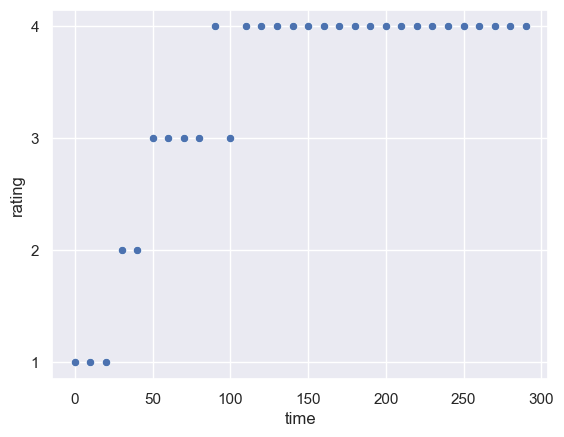

In [7]:
learner = MysteryLearner(card, seed=0x1337BEEF)
learner.initialize(rating = srs.Rating.AGAIN)

# pd is pandas, a library for working with tables (or "data frames").
# The pandas documentation is here: https://pandas.pydata.org/pandas-docs/version/2.3/index.html
ratings = pd.DataFrame([
    {
        "time": i * 10,
        "rating": learner.review(dt = 10),
    }
    for i in range(30)
])

# sns is seaborn, a data visualization library. 
# The seaborn documentation is here: https://seaborn.pydata.org/tutorial.html
ax = sns.scatterplot(data=ratings, x="time", y="rating")
_ = ax.set_yticks(range(1, 5))

*Remember that rating = the learner's attempt on a card. 1 means the card was the most difficult, 4 means the card was easy. What does the plotted trend indicate?*

Conversely, we can simulate a learner forgetting an item over time if they don't review it. In this example, we call the `recall_prob` function which computes the probability of recalling an item based on the time since the last review.

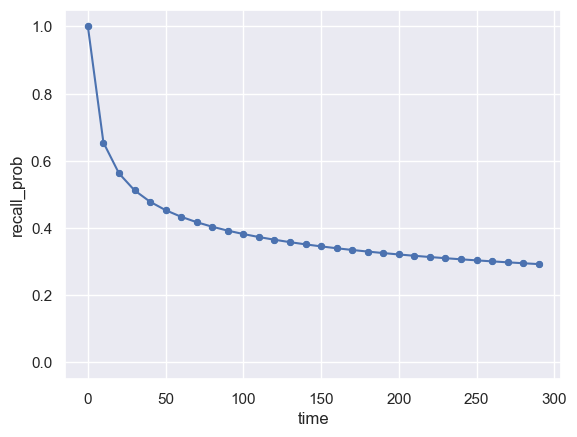

In [8]:
learner = MysteryLearner(card, seed=0x1337BEEF)
learner.initialize(rating = srs.Rating.EASY)
learner.review(5)

probs = pd.DataFrame([
    {
        "time": i * 10,
        "recall_prob": learner.recall_prob(dt = i * 10),
    }
    for i in range(30)
])

sns.lineplot(data=probs, x="time", y="recall_prob")
ax = sns.scatterplot(data=probs, x="time", y="recall_prob")
_ = ax.set_ylim([-0.05, 1.05])

--------------------------------------------

## Task 1 (15 points)

Our goal is to understand the properties of an SRS in aggregate, so we will need to move from analyzing a single simulation to many simulations. Write a notebook cell which runs the simulation from the previous cell 1,000 times (without the fixed random seed, and with a random card each time). Then plot the resulting distribution of recall probabilities at each time step.

**Notes:**
- `Card.sample` is a static method which returns a card of random difficulty.
- [`pd.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) can combine multiple dataframes.
- In Seaborn, you can ask it to visualize a dataframe which contains multiple `y` values for the same `x`. Seaborn will visualize either the *spread* of `y` at each `x` (e.g., inter-quartile range) or the *uncertainty* of `y` (e.g., confidence interval). You should be very careful to pick the appropriate visualization to your task. For this task, we recommend using a [boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html). For later tasks, consider using [error bars](https://seaborn.pydata.org/tutorial/error_bars.html) such as a percentile interval.

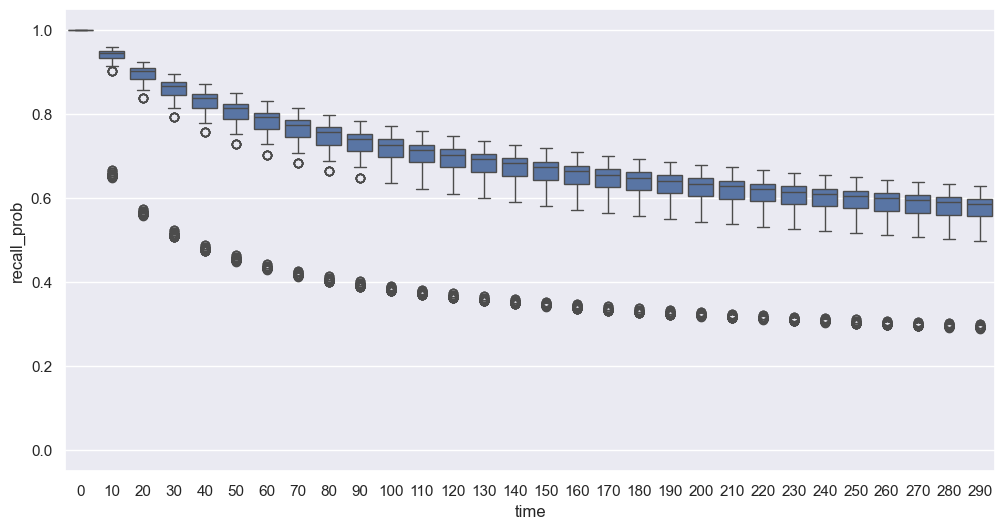

In [9]:
# Your answer goes here.
# YOUR ANSWER HERE

Answer the following questions:

1. Describe the shape of the distribution. Are there tails or outliers? How does the shape reflect the fact that learners are reviewing cards of varying difficulty?
2. Compare the recall probabilities of a single learner with card difficulty of 5 (the first plot) with the distribution of 1000 learners with random card difficulties. How does the distribution look different?
3. Looking at the median of the boxplot, when would a learner's recall drop below 60%?


*Write your answer here.*


--------------------------------------------

The final piece of our SRS API is a schedule, which dictates when a learner reviews an item. The simplest schedule is **uniform**, which consistently reviews an item every $I$ days for some $I$, such as $I = 20$. A schedule is a subclass of `srs.Schedule`:

In [ ]:
class UniformSchedule(srs.Schedule):
    def __init__(self, I):
        self.I = I

    def interval(self):
        return self.I

We have provided you a simulation function which takes a schedule, and returns a trace of the mystery learner using the schedule over a year. The trace includes a row for every day, not just days where reviews occurred. Each row contains the time, recall probability, whether the review occurred, and the user's rating if the review occurred (NaN otherwise). Here's what a sample trace looks like:

In [ ]:
# in this simulation, I = 20, meaning the mystery learner reviews items every 20 days.
data = simulations.simulate(UniformSchedule, seed=0x1337BEEF, I=20)
data

You can visualize this trace using Seaborn's `lineplot` function to produce an SRS's characteristic saw-tooth graph:

In [ ]:
ax = sns.lineplot(data, x="time", y="recall_prob")
_ = ax.set_ylim([-0.05, 1.05])

The schedule can be updated every time the learner performs a review. The `Schedule.update` method takes the learner's rating and the time since last review. A simple updating schedule is an *expanding* schedule, which always doubles the review interval:

In [ ]:
class ExpandingSchedule(srs.Schedule):
    def __init__(self):
        self.I = 1

    def interval(self):
        return self.I

    def update(self, _rating, _dt):
        self.I *= 2

data = simulations.simulate(ExpandingSchedule, seed=0x1337BEEF)
ax = sns.lineplot(data, x="time", y="recall_prob")
_ = ax.set_ylim([-0.05, 1.05])

----------

## Task 2 (10 points)

In a few sentences, explain how the difference in shape between the previous two graphs is related to the choice of schedule.

*Your answer here.*


--------

Like before, we want to move from a single run to many simulations. The code below runs 1000 simulations using the expanding schedule (again removing the random seed), and visualizes the spread of results using a 75% percentile interval:

In [ ]:
data = simulations.simulate_many(ExpandingSchedule, N=1000)
ax = sns.lineplot(data, x="time", y="recall_prob", estimator="median", errorbar=("pi", 75))
_ = ax.set_ylim([-0.05, 1.05])

------ 

## Task 3 (15 points)

Imagine the learner had a test on day 100 and wants to cram for the test. Write a schedule that causes the learner to review on days 95-99, simulate it 1,000 times, and plot the recall probability over time like the cell above.

In [ ]:
class CrammingSchedule(srs.Schedule):
    """
    A schedule that reviews frequently right before a fixed test date.
    
    Hint: interval() returns the number of days until the next review.
    Hint: update() is called after each review and can update internal state
          to change what interval() returns next.
    """
    def interval(self):
        raise NotImplementedError

    def update(self, rating, dt):
        raise NotImplementedError

# YOUR ANSWER HERE

**Answer the following question:**
Using the percentile interval shown in the plot, what is the approximate range of recall probabilities at the end of the year?

*Your answer here.*


------ 


# Part B. Designing a Schedule

No schedule is perfect, but some schedules are better than others, depending on your goals. The basic trade-off is effort vs. recall: how often a learner studies, versus how well they recall the material. Below, we run each existing schedule in simulation, and compute a variety of metrics:

In [ ]:
schedules = [
    (UniformSchedule, {"I": 5}, "uniform-5"),
    (UniformSchedule, {"I": 20}, "uniform-20"),
    (UniformSchedule, {"I": 100}, "uniform-100"),
    (CrammingSchedule, {}, "cramming"),
    (ExpandingSchedule, {}, "expanding"),
]

metrics = pd.concat([
    simulations.eval_metrics(simulations.simulate_many(Schedule, N=1000, **kwargs), name)
    for (Schedule, kwargs, name) in schedules
])

metrics

A first question is how can we summarize the effect of a schedule on recall? In our metrics, we track three kinds of recall. First, `exam_recall` is recall at time $T = 100$ of our hypothetical exam on day 100. Below, we plot the number of reviews (x-axis) against the exam recall (y-axis) of each schedule:

In [ ]:
simulations.scatterplot_annot(metrics, x="num_reviews", y="exam_recall", label="schedule")

**Consider:** which direction on this plot is desirable? That is, we want schedules which move towards which quadrant?

Clearly, cramming is the optimal strategy to maximize exam recall with respect to effort. Rather than looking at any individual day's recall, we can consider the average recall over all days of the year:

In [ ]:
simulations.scatterplot_annot(metrics, x="num_reviews", y="avg_recall", label="schedule")

This graph shows us our [Pareto frontier](https://en.wikipedia.org/wiki/Pareto_front). Our goal is to produce new algorithms which either:
1. Given a number of reviews, increases recall. Or,
2. Given a level of recall, decreases number of reviews.

That is, we seek to move up and to the left.


----------

## Task 4 (20 points)

To start, you will reimplement a known algorithm: SuperMemo-2, which we discussed in lecture. 
1. Implement the SM2 schedule, evaluate its recall metrics over 1,000 simulations (avg_recall and num_reviews), and plot its performance vs. our existing schedules on the previous scatterplot.
2. Add an option to your SM2 implementation so that it does not use the "easiness factor", and instead fixes $EF = 2$. Evaluate the performance of this simplified algorithm.

In [ ]:
class Sm2(srs.Schedule):
    """
    Implement SM-2.
    """

    def __init__(self, use_ef):
        raise NotImplementedError

    def interval(self):
        raise NotImplementedError

    def update(self, rating, dt):
        raise NotImplementedError

# TODO: evaluate metrics for SM2 with EF and without EF (1,000 sims each)
# YOUR ANSWER HERE

In [ ]:
# TODO: add both to the existing scatterplot of schedules
# YOUR ANSWER HERE

Answer the following questions:
1. Which schedules are **strictly** outperformed by SM2, meaning they are objectively worse than SM2 in terms of our two metrics?
2. What is the difference between the performance of SM2 with and without the easiness factor? Why does removing the easiness factor cause this difference?

*Your answer here.*



----------------

Your final challenge is going to be to design a new algorithm which outperforms SM-2. Rather than open-ended trial-and-error, we are going to narrow the problem in the style of modern SRS algorithms. Briefly, some context:

Every SRS algorithm is trying to do two things. 
1. Figure out the **strength** of a person's memory for an item.
2. Deduce the optimal **interval** to increase strength over time.

Algorithms like SuperMemo-2 don't cleanly distinguish between these concerns. But it's possible to solve these problems independently, and then put them together. Consider trying to solve Problem #2, given a solution for Problem #1. That is, you have a model of memory, and want to deduce intervals. A simple approach (used for a while by Duolingo, I believe) is a **threshold schedule**:

In [ ]:
class ThresholdSchedule(srs.Schedule):
    def __init__(self, model, threshold=0.95):
        self.model = model
        self.threshold = threshold

    def initialize(self, rating):
        self.model.initialize(rating)

    def interval(self):
        for I in range(2, 365):
            if self.model.recall_prob(I) < self.threshold:
                return I - 1
        return 365

    def update(self, rating, dt):
        self.model.update(rating, dt)

A threshold schedule takes as input a model of someone's memory and a target threshold. The goal is to never let the user's recall accuracy drop below the threshold. The implementation of `interval` shows one approach to this goal. Increase the interval $I$ until recall drops below the threshold, and make that our next interval. (If you're curious about more sophisticated approaches than a threshold, see the [MEMORIZE algorithm](https://learning.mpi-sws.org/memorize/).)

**Goal of threshold schedule: schedule the next review before recall drops below the threshold.**

This schedule should perform well if given access to a "gold standard" model of the learner's memory. For example, below is a "cheating" simulation which instantiates `ThresholdSchedule` with exactly `MysteryLearner` given the sampled `Card`. Notice how the recall immediately jumps up after hitting 0.95, indicating that this threshold schedule is performing as expected.

In [ ]:
data = simulations.cheating_simulate(ThresholdSchedule, seed=0x1337BEEF)
ax = sns.lineplot(data, x="time", y="recall_prob")
_ = ax.set_ylim([0.85, 1.01]) # note the change in y-axis limits

However, your SRS doesn't get access to the actual learner, so you will have to make a proxy model for the learner's probability of recall. We will use a framework inspired by Duolingo's [halflife regression](https://research.duolingo.com/papers/settles.acl16.pdf) framework. In short, we can model the probability of recall with the equation:

$$P(\text{recall}) = 2^{-\Delta / h}$$

Where $\Delta$ is the change in time (`dt`), and $h$ is the *half-life* of the memory, i.e., the amount of time it takes for recall to drop by 50%. A key intuition is that larger half-life means a stronger memory: if h is larger, the exponent 
$-\Delta/h$ approaches $0$, so $2^{-\Delta / h}$ approaches 1, i.e., recall decays more slowly over time. This equation is represented by the `HalflifeLearner`:

In [ ]:
class HalflifeLearner(srs.Learner):
    def __init__(self, model):
        self.model = model

    def initialize(self, rating):
        self.model.initialize(rating)
        
    def recall_prob(self, dt):
        return 2 ** (-dt / self.model.h())

    def update(self, rating, dt):
        self.model.update(rating, dt)

The challenge is to implement a model of `h` which updates based on the learner's behavior. A simple baseline is to reimplement a variant of the Leitner box algorithm, where the half-life doubles for every correct answer, and halves for every incorrect answer. That is implemented as follows:

In [ ]:
class Leitner:
    def __init__(self):        
        self.n_right = 0
        self.n_wrong = 0

    def initialize(self, rating):
        self.update(rating, 0)

    def h(self):
        return 2 ** (self.n_right - self.n_wrong)

    def update(self, rating, _dt):
        if rating > 1:
            self.n_right += 1
        else:
            self.n_wrong += 1

If we simulate the threshold schedule using the halflife learner under the Leitner model, then our model is less effective than before at preventing recall from crossing the 0.95 threshold:

In [ ]:
data = simulations.simulate(lambda: ThresholdSchedule(HalflifeLearner(Leitner())), seed=0x1337BEEF)
ax = sns.lineplot(data, x="time", y="recall_prob")
_ = ax.set_ylim([0.85, 1.01])

We can summarize this difference in behavior using the metrics from before.

In [ ]:
ts_leitner_metrics = simulations.eval_metrics(simulations.simulate_many(
    lambda: ThresholdSchedule(HalflifeLearner(Leitner())), N=1000), "ts-leitner")
ts_ideal_metrics = simulations.eval_metrics(simulations.cheating_simulate_many(
    ThresholdSchedule, N=1000), "ts-ideal")

In [ ]:
simulations.scatterplot_annot(
    pd.concat([sm2_ef_metrics, sm2_no_ef_metrics, ts_leitner_metrics, ts_ideal_metrics]), 
    x="num_reviews", y="avg_recall", label="schedule")

Observe that `ts-leitner` is objectively worse than SM-2 (with EF), while `ts-ideal` is objectively better. 

# Task 5 (40 Points)

Your challenge is to implement a half-life model which is as close as possible to `ts-ideal`. Some things to consider about the learner:

1. A higher card difficulty leads to weaker memories (smaller half-life).
2. The learner provides a rating from 1-4, and higher ratings indicate stronger memories.
3. As in systems like Anki or Duolingo, you can generate large amounts of data that describe the mystery learner’s recall probability under different conditions. You can analyze this data to understand its behavior, or use it to tune your model's parameters.

Your grade on this task will be the number in the `score` column of the computed metrics, which combines review/recall metrics into a single number. Your score will vary across simulations, so run it with a high number (N=10000) to get a robust estimate.

In [ ]:
class MyModel:
    def initialize(self, rating):
        pass

    def update(self, rating, dt):
        pass

    def h(self):
        return 400.

# YOUR ANSWER HERE

In [ ]:
# TODO: add both to the existing scatterplot of schedules
# YOUR ANSWER HERE

**Before you're done:** make sure to run Kernel > Restart and Run All. Your notebook should run without errors from top-to-bottom.

Once you've verified that's true, submit this file to Gradescope.